Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import random

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

from tqdm.notebook import tqdm, trange

Utils

In [ ]:
def set_device():
    """
    Set the device. CUDA if available, CPU otherwise

    Args:
      None

    Returns:
      Nothing
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
              "if possible, in the menu under `Runtime` -> "
              "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

def set_seed(seed=None, seed_torch=True):
    """
    Function that controls randomness.
    NumPy and random modules must be imported.

    Args:
      seed : Integer
        A non-negative integer that defines the random state. Default is `None`.
      seed_torch : Boolean
        If `True` sets the random seed for pytorch tensors, so pytorch module
        must be imported. Default is `True`.

    Returns:
      Nothing.
    """
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    """
    DataLoader will reseed workers following randomness in
    multi-process data loading algorithm.

    Args:
      worker_id: integer
        ID of subprocess to seed. 0 means that
        the data will be loaded in the main process
        Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

    Returns:
      Nothing
    """
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

# Just returns accuracy on test data
def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = torch.squeeze(labels.to(device).long())

    outputs = model(inputs)

    # _, predicted = torch.max(outputs, 1)
    predicted = torch.squeeze((outputs>0.5).float())
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

Data

In [ ]:
class NeuronsDataset(Dataset):
    """Binary neuron classifier dataset
    """
    
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.images = torch.from_numpy(data['data'])
        self.images = self.images[: , None]
        self.labels = torch.from_numpy(data['labels'])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, id):   
        return self.images[:][id], self.labels[id]

      
def load_data(dataset, test_split, val_split):
    """
    dataset: from the Dataset class
    test_split, var_split: float in [0,1]
    """

    y = dataset.labels
    '''
    X = dataset.images

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

    train_data = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, num_workers=2)
    val_data = DataLoader(val_subset, batch_size=len(val_subset), shuffle=True, num_workers=2)
    test_data = DataLoader(test_subset, batch_size=len(test_subset), shuffle=True, num_workers=2)
    '''

    X_train_i, X_test_i, y_train, y_test = train_test_split(range(len(y)), y, test_size = test_split,  stratify=y)
    X_train_i, X_val_i, y_train, y_val = train_test_split(X_train_i, y_train, test_size = val_split,  stratify=y_train)

    train_subset = Subset(dataset, X_train_i)
    val_subset = Subset(dataset, X_val_i)
    test_subset = Subset(dataset, X_test_i)
    
    train_data = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, num_workers=2)
    val_data = DataLoader(val_subset, batch_size=len(val_subset), shuffle=True, num_workers=2)
    test_data = DataLoader(test_subset, batch_size=len(test_subset), shuffle=True, num_workers=2)

    return train_data, val_data, test_data

def load_train_val_data(dataset, val_split):
    """
    dataset: from the Dataset class
    var_split: float in [0,1]
    """

    y = dataset.labels
    '''
    X = dataset.images

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

    train_data = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, num_workers=2)
    val_data = DataLoader(val_subset, batch_size=len(val_subset), shuffle=True, num_workers=2)
    test_data = DataLoader(test_subset, batch_size=len(test_subset), shuffle=True, num_workers=2)
    '''

    X_train_i, X_val_i, y_train, y_val = train_test_split(range(len(y)), y, test_size = val_split,  stratify=y)

    train_subset = Subset(dataset, X_train_i)
    val_subset = Subset(dataset, X_val_i)
    
    train_data = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, num_workers=2)
    val_data = DataLoader(val_subset, batch_size=len(val_subset), shuffle=True, num_workers=2)

    return train_data, val_data

def load_test_data(test_dataset):
    test_data = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=2)
    return test_data


Random seed 2021 has been set.
cpu


  0%|          | 0/200 [00:00<?, ?epoch/s]

Test accuracy is: 94.36052366565961%


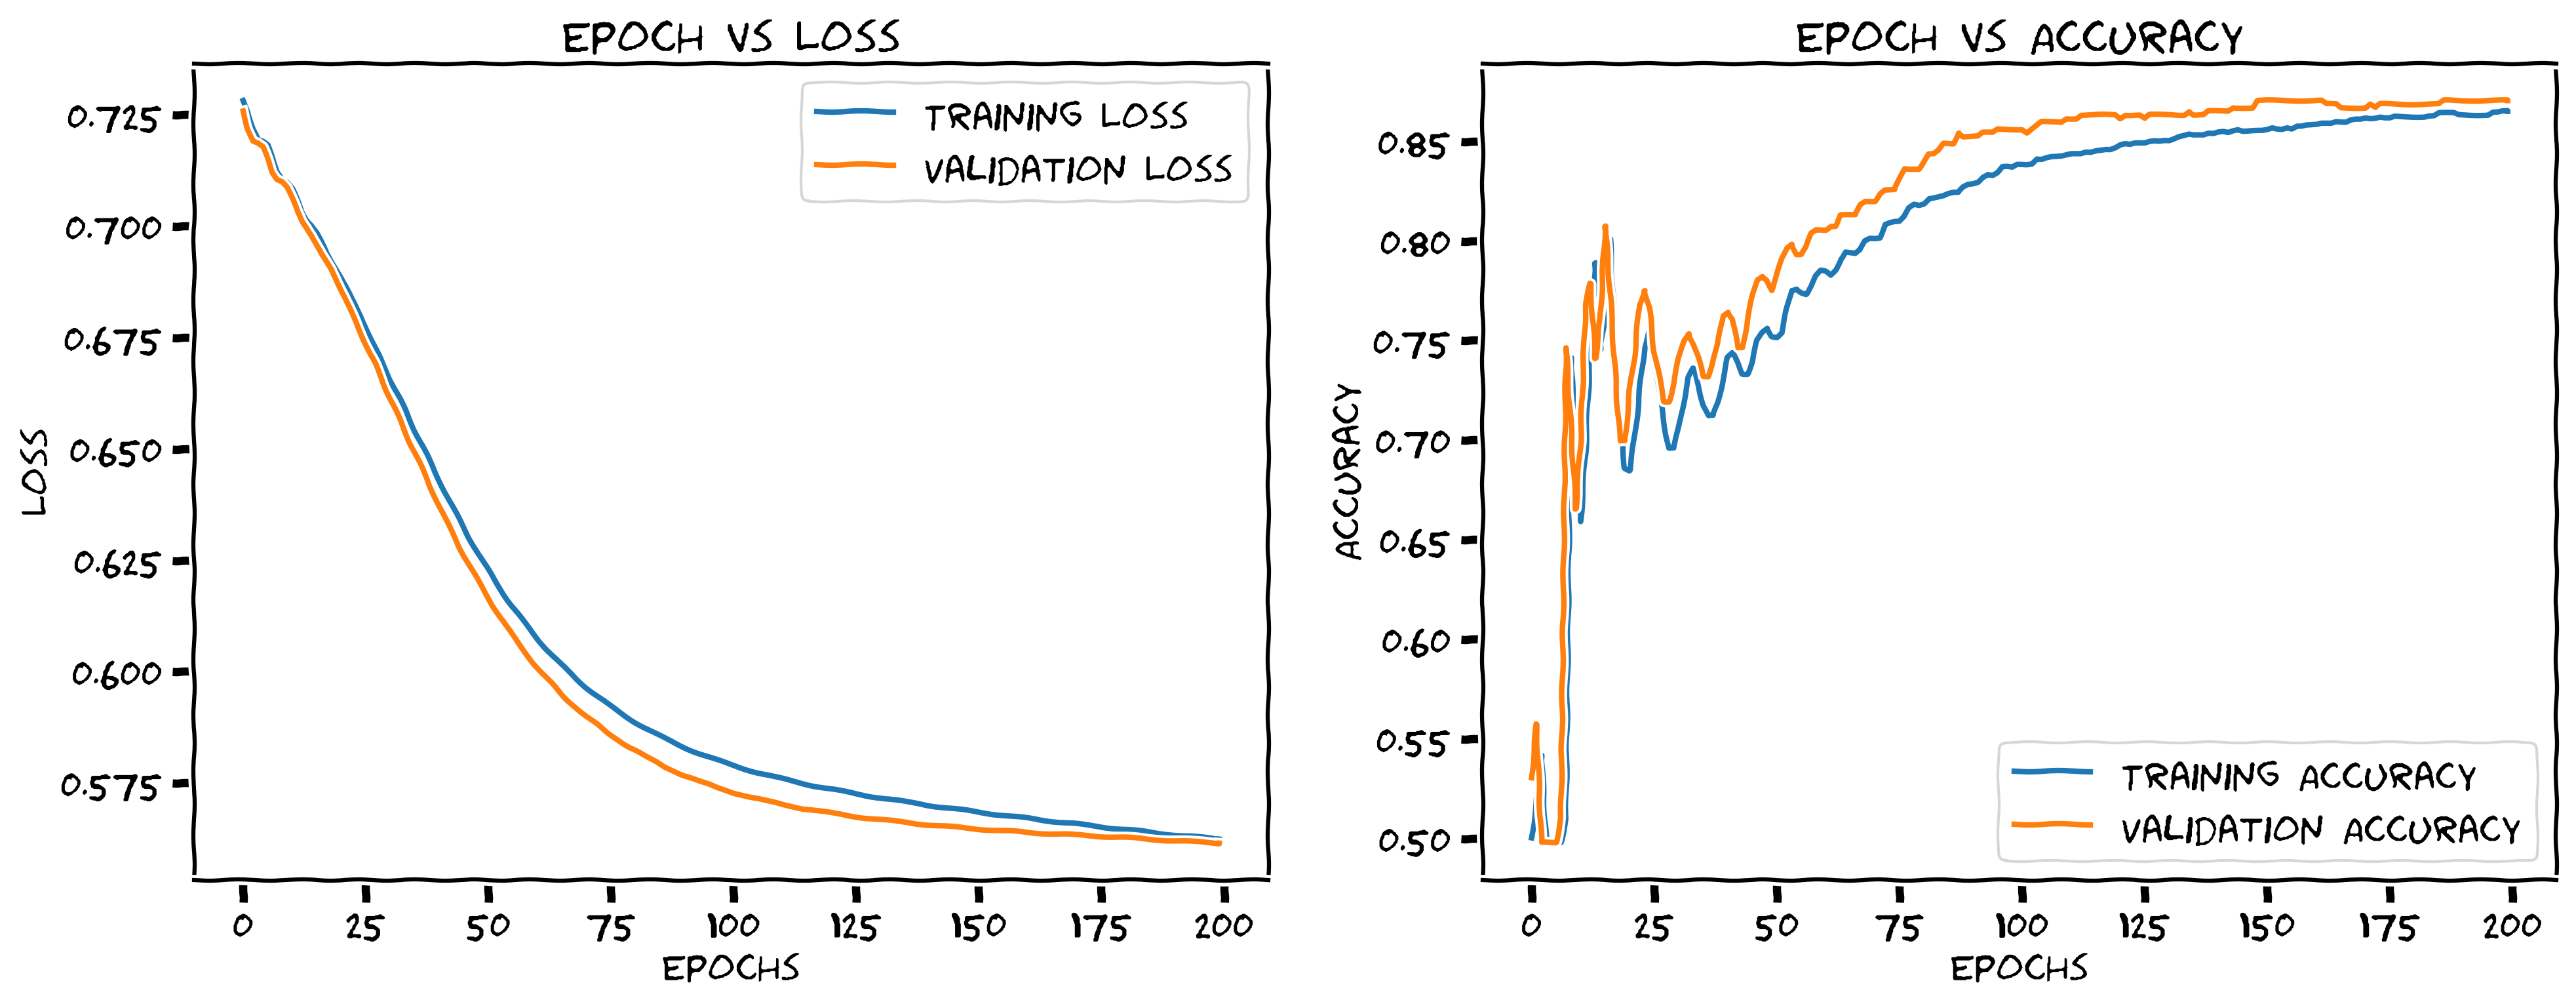

In [ ]:
class neuron_net(nn.Module):
    """
    Create a sample network
    """

    def __init__(self):
        """
        Initialise parameters of sample network

        Args:
          None

        Returns:
          Nothing
        """
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(256, 128) 
        self.fc2 = nn.Linear(128, 1) 

    def forward(self, x):
        """
        Forward pass of sample network

        Args:
          x: torch.tensor
            Input features

        Returns:
          x: torch.tensor
            Output after passing through sample network
        """
        # Conv layer 1.
        x = x.float() # added this
        # print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.shape)

        # Conv layer 2.
        x = self.conv2(x)
        #print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.shape)


        # Fully connected layer 1.
        # First flatten the ourput from the previous convolution layer
        x = x.view(-1, 2*2*64) # used to be -1, 9*9*64
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)

        x = F.relu(x)

        # Fully connected layer 2.
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)


        return torch.sigmoid(x) # converted to float

def train(model, device, train_loader, validation_loader, epochs):
  """
  Training loop

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    epochs: int
      Number of epochs
    train_loader: torch.loader
      Training Set
    validation_loader: torch.loader
      Validation set

  Returns:
    Nothing
  """
  criterion =  nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # Keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for data, target in train_loader:
        data, target = data.to(device), torch.squeeze(target.to(device))

        # 1. Get the model output (call the model with the data from this batch)
        # output = torch.sigmoid(model(data))
        output = model(data)

        # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
        #                       has collected so far with optimizer.zero_grad())
        optimizer.zero_grad()

        # 3. Get the Loss (call the loss criterion with the model's output
        #                  and the target values)
        loss = criterion(torch.squeeze(output), torch.squeeze(target.float()))

        # 4. Calculate the gradients (do the pass backwards from the loss
        #                             with loss.backward())
        loss.backward()

        # 5. Update the weights (using the training step of the optimizer,
        #                        optimizer.step())
        optimizer.step()

        # Set loss to whatever you end up naming your variable when
        # calling criterion
        # For example, loss = criterion(output, target)
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()  # Add the loss for this batch

        # Get accuracy
        # _, predicted = torch.max(output, 1)
        predicted = torch.squeeze((output>0.5).float())

        total += target.size(0)
        correct += (predicted == target).sum().item()

      train_loss.append(running_loss / len(train_loader))  # Append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
      train_acc.append(correct / total)

      # Evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for data, target in validation_loader:
        data, target = data.to(device), torch.squeeze(target.to(device))
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(torch.squeeze(output), torch.squeeze(target.float()))
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # Get accuracy
        # _, predicted = torch.max(output, 1)
        predicted = torch.squeeze((output>0.5).float())

        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss / len(validation_loader))
      validation_acc.append(correct / total)

  return train_loss, train_acc, validation_loss, validation_acc

def main():
    SEED = 2021
    set_seed(seed=SEED)
    DEVICE = set_device()
    print(DEVICE)

    # dataset = NeuronsDataset(npz_file = "2P_lindsey_data.npz")

    train_val_dataset = NeuronsDataset(npz_file = "2P_suhan_data.npz")
    test_dataset = NeuronsDataset(npz_file = "2P_lindsey_data.npz")
    # train_data, val_data, test_data = load_data(dataset, 0.2, 0.25)
    train_data, val_data = load_train_val_data(train_val_dataset, 0.2)
    test_data = load_test_data(test_dataset)

    model = neuron_net().to(DEVICE)
    '''
    num_epochs = 3

    train_loss, validation_loss = train(model,
                                             DEVICE,
                                             train_loader,
                                             test_loader,
                                             num_epochs)

    epochs = [x for x in range(1, 4)]
    plt.xlabel("Epoch")
    plt.plot(epochs, train_loss, '-o', label='Training')
    plt.plot(epochs, validation_loss, '-o', label='Validation')
    plt.legend()
    plt.show()
    '''

    ## Uncomment to test your training loop
    train_loss, train_acc, validation_loss, validation_acc = train(model, DEVICE, train_data, val_data, 200)
    print(f'Test accuracy is: {test(model, DEVICE, test_data)}')


    ideal_train_loss = [(1 - 0.09*x)+random.uniform(-0.05, 0.05) for x in range(10)]
    for x in range(5):
        ideal_train_loss.append(0.05+random.uniform(-0.03,0.03))

    ideal_val_loss = [(1 - 0.09*x)+random.uniform(-0.05, 0.05) for x in range(7)]
    for x in range(8):
        ideal_val_loss.append(0.2+0.02*x + random.uniform(-0.02,0.02))

    ideal_train_acc = [0.5+0.045*x+random.uniform(-0.05, 0.05) for x in range(10)]
    for x in range(5):
        ideal_train_acc.append(0.95+random.uniform(-0.03,0.03))

    ideal_val_acc = [0.5+0.045*x+random.uniform(-0.05, 0.05) for x in range(7)]
    for x in range(8):
        ideal_val_acc.append(0.85+random.uniform(-0.02,0.02))


    with plt.xkcd():
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['savefig.dpi'] = 300
        plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
        # plot_loss_accuracy(ideal_train_loss, ideal_train_acc, ideal_val_loss, ideal_val_acc)




    
if __name__ == "__main__":
    main()